In [1]:
import pykep as pk 
import numpy as np 
import heyoka as hy

import pygmo as pg
import pygmo_plugins_nonfree as ppnf

In [3]:
when = pk.epoch(64328, pk.core.epoch.julian_type.MJD)
raw_data = np.loadtxt("GTOC12_Asteroids_Data.txt", skiprows=1)[:,2:]
raw_data[:,2:]*=pk.DEG2RAD
raw_data[:,0]*=pk.AU

In [3]:
earth = pk.planet(pk.udpla.keplerian(pk.epoch(64328, pk.epoch.julian_type.MJD),
                            (1.49579151285E8*1000, 1.65519129162E-2, 4.64389155500E-3 * pk.DEG2RAD,
                             1.98956406477e2 * pk.DEG2RAD, 2.62960364700e2 * pk.DEG2RAD, 3.58039899470e2 * pk.DEG2RAD),
                            pk.MU_SUN,
                            "earth", el_type=pk.el_type.KEP_M))

gtoc12_asts = [earth]
for i, elements in enumerate(raw_data):
    gtoc12_asts.append(pk.planet(pk.udpla.keplerian(when, elements, pk.MU_SUN, "gtoc12 ast-"+str(i+1), el_type=pk.el_type.KEP_M)))

## The Orbital Metric

In [4]:
# We check what asteroids are close to each other at epoch mjd2000 = 5500
when = pk.epoch(5500)
tof_days = 200
knn_instance = pk.knn(gtoc12_asts, when, tof=tof_days)
# And find the closest 5 neighbours to the asteroid with id=24
ast_id_ref = 24
neighbours_names, neighbours_idxs, neighbours_dists = knn_instance.find_neighbours(ast_id_ref, k = 10)

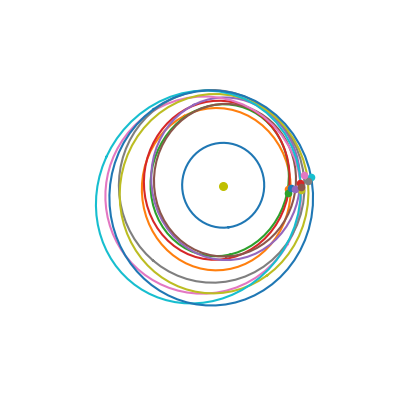

In [5]:
ax = pk.plot.make_3Daxis(figsize=(5,5))
pk.plot.add_sun(ax)
pk.plot.add_planet_orbit(ax, earth)
for id in neighbours_idxs:
    pk.plot.add_planet_orbit(ax, gtoc12_asts[id])
    pk.plot.add_planet(ax, gtoc12_asts[id], when)
ax.view_init(90,90)
ax.axis('off');

Clearly the neighbours found are approximately well phased asteroids that can be considered for a transfer (a hop). The above computation is extremely quick to make, so that for the asteroids found we can afford to complexify our trajectory model. For example computing now the transfer Maximum initial mass approximations (which are also computationally light as they require only Lambert arc computations)

## The Maximum Initial Mass Approximations - MIMA(s)

In [6]:
Tmax = 0.6
Isp = 4000

r,v = gtoc12_asts[ast_id_ref].eph(when)
for idx in neighbours_idxs[1:]:
    posvel_f = gtoc12_asts[idx].eph(when + tof_days)
    l = pk.lambert_problem(r, posvel_f[0], tof = tof_days*pk.DAY2SEC, mu=pk.MU_SUN)
    dv1 = [a-b for a,b in zip(l.v0[0],v)]
    dv2 = [a-b for a,b in zip(posvel_f[1], l.v1[0])]
    mima = pk.mima(dv1, dv2, tof_days*pk.DAY2SEC, Tmax=Tmax, veff = pk.G0 * Isp)[0]
    posvel = [r, l.v0[0]]
    mima2 = pk.mima2(posvel, dv1, dv2, tof_days*pk.DAY2SEC, Tmax=Tmax, veff = pk.G0 * Isp, mu = pk.MU_SUN)[0]
    print(f"idx: {idx}: mima: {mima:.8f}, mima2: {mima2:.8f}")


idx: 56806: mima: 1270.16102850, mima2: 1336.53752329
idx: 21298: mima: 1376.28433396, mima2: 1349.12057368
idx: 11241: mima: 805.84627823, mima2: 764.22499061
idx: 17333: mima: 966.96031125, mima2: 942.28767024
idx: 58382: mima: 899.57118064, mima2: 981.70709084
idx: 9791: mima: 952.07569132, mima2: 939.52952745
idx: 59398: mima: 868.63412492, mima2: 849.81378715
idx: 13156: mima: 892.72968973, mima2: 899.41910901
idx: 55344: mima: 838.49574444, mima2: 808.47917624


Theres a very good correlation between the ranking assembled by the orbital metric and that of the MIMA. Note, though, that the resulting ranking is sensitive to the value set for the time of flight.

In [10]:
for idx in neighbours_idxs[1:]:
    mim = pk.trajopt.mim_from_hop(gtoc12_asts[24], gtoc12_asts[idx], when, when + 200, 0.6, 4000*pk.G0)
    print(f"idx: {idx}: mim: {mim:.8f}")


idx: 56806: mim: 1305.48251359
idx: 21298: mim: 1324.55549833
idx: 11241: mim: 734.44284846
idx: 17333: mim: 918.53320330
idx: 58382: mim: 1042.69839937
idx: 9791: mim: 969.96312433
idx: 59398: mim: 851.56412185
idx: 13156: mim: 888.98952310
idx: 55344: mim: 815.63342957


## The minimum transfer time (not approximated)

In [8]:
# Factory for the pygmo problem.
def prob_factory(ast_id_s, ast_id_t, T_max, tof_guess, when):
    udp = pk.trajopt.pontryagin_cartesian_time(
        source= gtoc12_asts[ast_id_s],
        target= gtoc12_asts[ast_id_t],
        tof_guess=tof_guess,
        t0 = when,
        T_max=T_max,
        Isp=3000,
        m0=1500,
        L=pk.AU,
        TIME=pk.YEAR2DAY * pk.DAY2SEC,
        MASS=1500,
        with_gradient=True,
    )
    prob = pg.problem(udp)
    prob.c_tol = 1e-6
    return prob

# Factory for the pygmo algorithm.
def algo_factory(max_iter):
    ip = pg.ipopt()
    ip.set_integer_option("max_iter", max_iter)  # Change the maximum iterations
    ip.set_integer_option("print_level", 0)  # Makes Ipopt unverbose
    ip.set_string_option(
        "nlp_scaling_method", "none"
    )  # Removes any scaling made in auto mode
    ip.set_string_option(
        "mu_strategy", "adaptive"
    )  # Alternative is to tune the initial mu value
    return pg.algorithm(ip)

In [9]:
masses = []
times = []
xs = []
for idx_t in neighbours_idxs[1:]:
    prob = prob_factory(24, idx_t, 0.6, 250, when)
    algo = algo_factory(100)
    udp = prob.extract(pk.trajopt.pontryagin_cartesian_time)
    for i in range(100):
        pop = pg.population(prob, 1)
        pop = algo.evolve(pop)
        if prob.feasibility_f(pop.champion_f):
            udp.fitness(pop.champion_x)
            masses.append(udp.ta.state[6])
            times.append(pop.champion_x[-1]*udp.TIME*pk.SEC2DAY)
            break
        else:
            print("x", end="")
    print(f"idx: {idx_t}: minumum time: {times[-1]:.2f}, mass: {masses[-1]*udp.MASS:.2f}")


xidx: 56806: minumum time: 228.61, mass: 1097.18
idx: 21298: minumum time: 219.98, mass: 1112.37
xidx: 11241: minumum time: 355.47, mass: 873.63
idx: 17333: minumum time: 285.46, mass: 997.00
idx: 58382: minumum time: 236.69, mass: 1082.94
idx: 9791: minumum time: 247.80, mass: 1063.37
idx: 59398: minumum time: 276.69, mass: 1012.46
idx: 13156: minumum time: 282.90, mass: 1001.51
idx: 55344: minumum time: 292.73, mass: 984.18
